In [67]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import functools
import riot # riot / ot homemade library

# RIOT study

## functions

In [68]:
# function to generate distance matrix for n points located in x-dim space
def distance_matrix_generation (n,dim = 2, seed = 42):
    '''
    generates euclidian distance matrix 
    for n points generated in a dim dimension space 
    '''
    np.random.seed(seed)
    x =  np.random.randn(n,dim)
    return ((x[:,None,:] - x[None,:,:])**2).sum(2)**0.5

In [69]:
# function to generate synthetic data
def datagen(seed, n, m, u_feat, v_feat, a_rank, noise, gamma = 0.1, const = 1, deg = 1):
    
    rand_gen = np.random.RandomState(seed)

    U = rand_gen.rand(n,u_feat)
    V = rand_gen.rand(m,v_feat)
    G_real = rand_gen.rand(u_feat, a_rank)
    D_real = rand_gen.rand(v_feat, a_rank)
    A_real = G_real @ D_real.T
    C_real = riot.poly_kernel(U, V, gamma, const, deg, A_real)
    mu_real, nu_real = rand_gen.rand(n,1), rand_gen.rand(m,1)
    mu_real /= mu_real.sum()
    nu_real /= nu_real.sum()
    Pi_real= riot.sinkhorn_stab(C_real, mu_real, nu_real)[0]
    C_u = distance_matrix_generation(n)
    C_v = distance_matrix_generation(m)

    Pi_hat = Pi_real + noise * np.abs(rand_gen.randn(n,m))
    Pi_hat /= Pi_hat.sum()
    return Pi_real, Pi_hat, U, V, C_u, C_v

In [70]:
# function to run riot on the generated synthetic data
def riot_run(Pi_hat, Pi_real, C_u, C_v, A_init,
             lambda0 = 1, lambda_u = 1, lambda_v = 1, 
             delta = 0.02, s = 100, outer_iter = 100, inner_iter = 30, 
             gamma = 0.05, const = 1, deg = 1) :
    
    C_of_A = functools.partial(riot.poly_kernel, U, V, gamma**2, const/gamma, deg)
    dC_of_A = functools.partial(riot.poly_kernel, U, V, deg * gamma**2, const/gamma, deg-1)
    def Delta_of_A (A, gradC) :
        return U.T @ (gradC * dC_of_A(A)) @ V
    return riot.RIOT(Pi_hat, C_u, C_v, C_of_A, Delta_of_A, 
                     lambda0, lambda_u,lambda_v, delta , s, 
                     outer_iter, inner_iter,None,A_init, Pi_real)

## first run

To make everything work 

### synthetic data generation

In [72]:
# generate the problem
seed = 42
rand_gen = np.random.RandomState(seed)

n, m = 10, 12
u_feat, v_feat = 9, 8
a_rank = 3

noise = 1e-4

Pi_real, Pi_hat, U, V, C_u, C_v = datagen(seed, n, m, u_feat, v_feat, a_rank, noise)

### RIOT run

In [73]:
# func test
A_init = rand_gen.rand(u_feat,v_feat)
_,_,KLs, PiDists = riot_run(Pi_hat, Pi_real, C_u, C_v, A_init,
                         lambda0 = 1, lambda_u = 1, lambda_v = 1, 
                         delta = 0.02, s = 100, outer_iter = 1000, inner_iter = 30, 
                         gamma = 0.05, const = 1, deg = 2)

Performing RIOT :


100% |########################################################################|


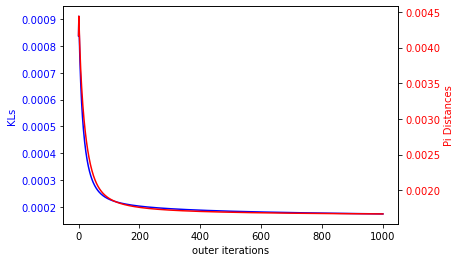

In [74]:
# ploting the convergence
i = list(range(len(KLs)))
fig, ax1 = plt.subplots()
ax1.set_xlabel('outer iterations')
ax1.set_ylabel('KLs', color='b')
ax1.plot(i, KLs, 'b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  

color = 'r'
ax2.set_ylabel('Pi Distances', color=color)  # we already handled the x-label with ax1
ax2.plot(i, PiDists, color=color)
ax2.tick_params(axis='y', labelcolor=color)

## noise sensitivity

here we see that for higher values of noise, we can't converge, 
however it seems we can reinforce convergence by augmenting regularisation

Performing RIOT :


100% |########################################################################|


for noise = 1e-05 we have the results


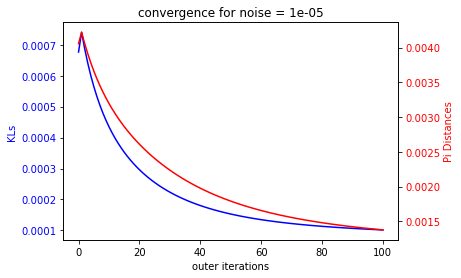

Performing RIOT :


100% |########################################################################|


for noise = 0.0001 we have the results


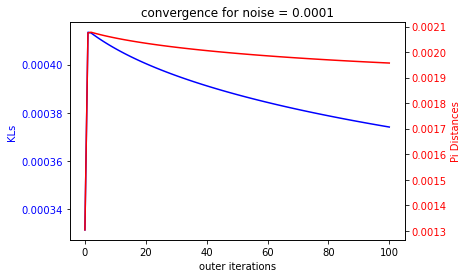

Performing RIOT :


100% |########################################################################|


for noise = 0.001 we have the results


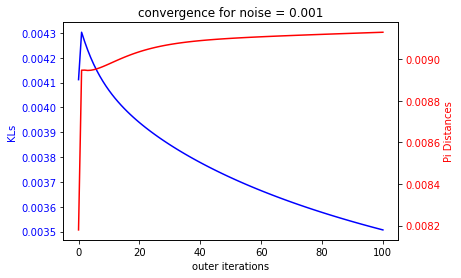

In [75]:
# generate the problem
seed = 42
rand_gen = np.random.RandomState(seed)

n, m = 10, 12
u_feat, v_feat = 9, 8
a_rank = 3

noise = 0

Pi_real, Pi_hat, U, V, C_u, C_v = datagen(seed, n, m, u_feat, v_feat, a_rank, noise)
A_init = rand_gen.rand(u_feat,v_feat)

for noise in [1e-5, 1e-4, 1e-3] : 
    Pi_hat = Pi_real + noise * np.abs(rand_gen.randn(n,m))
    Pi_hat /= Pi_hat.sum()
    _,_,KLs, PiDists = riot_run(Pi_hat, Pi_real, C_u, C_v, A_init,
                             lambda0 = 1, lambda_u = 1, lambda_v = 1, 
                             delta = 0.02, s = 100, outer_iter = 100, inner_iter = 30, 
                             gamma = 0.05, const = 1, deg = 2)
    print(f'for noise = {noise} we have the results')
    i = list(range(len(KLs)))
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('outer iterations')
    ax1.set_ylabel('KLs', color='b')
    ax1.plot(i, KLs, 'b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()  

    color = 'r'
    ax2.set_ylabel('Pi Distances', color=color)  # we already handled the x-label with ax1
    ax2.plot(i, PiDists, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(f"convergence for noise = {noise}")
    plt.show()